In [5]:
!pip install -Uqq ipdb
import ipdb
!pip install plotly
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

!pip install sweetviz
#!pip install -U geometric-smote #пробуем балансировать cv_dataset
!pip install shap
!pip install smogn
#!pip install focal-loss

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [6]:
!pip  install tpot

In [7]:
!pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.6 MB/s eta 0:00:00


In [8]:
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
import os

import numpy as np
import pandas as pd
from pandas.io.formats.format import NA

import catboost as cb

from sklearn.metrics import classification_report, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import shap
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import matplotlib.animation as animation
import seaborn as sns

import sweetviz as sw
%matplotlib inline

#from gsmote import GeometricSMOTE

# очистка ОЗУ
import gc

import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
#@title Монтируем Google Drive
from google.colab import drive
#drive.mount('/content/drive')

/content/drive/MyDrive/Warfarin/dataForAll.xlsx:1917 записей


                                             |          | [  0%]   00:00 -> (? left)


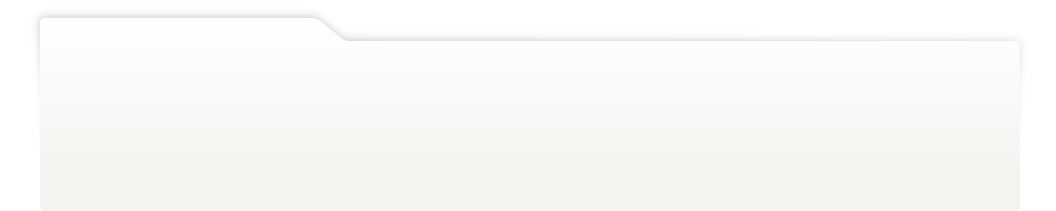
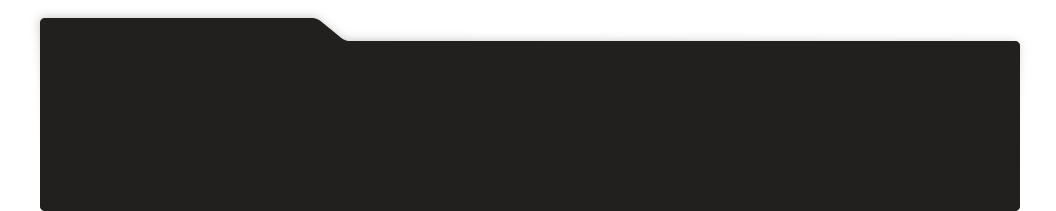
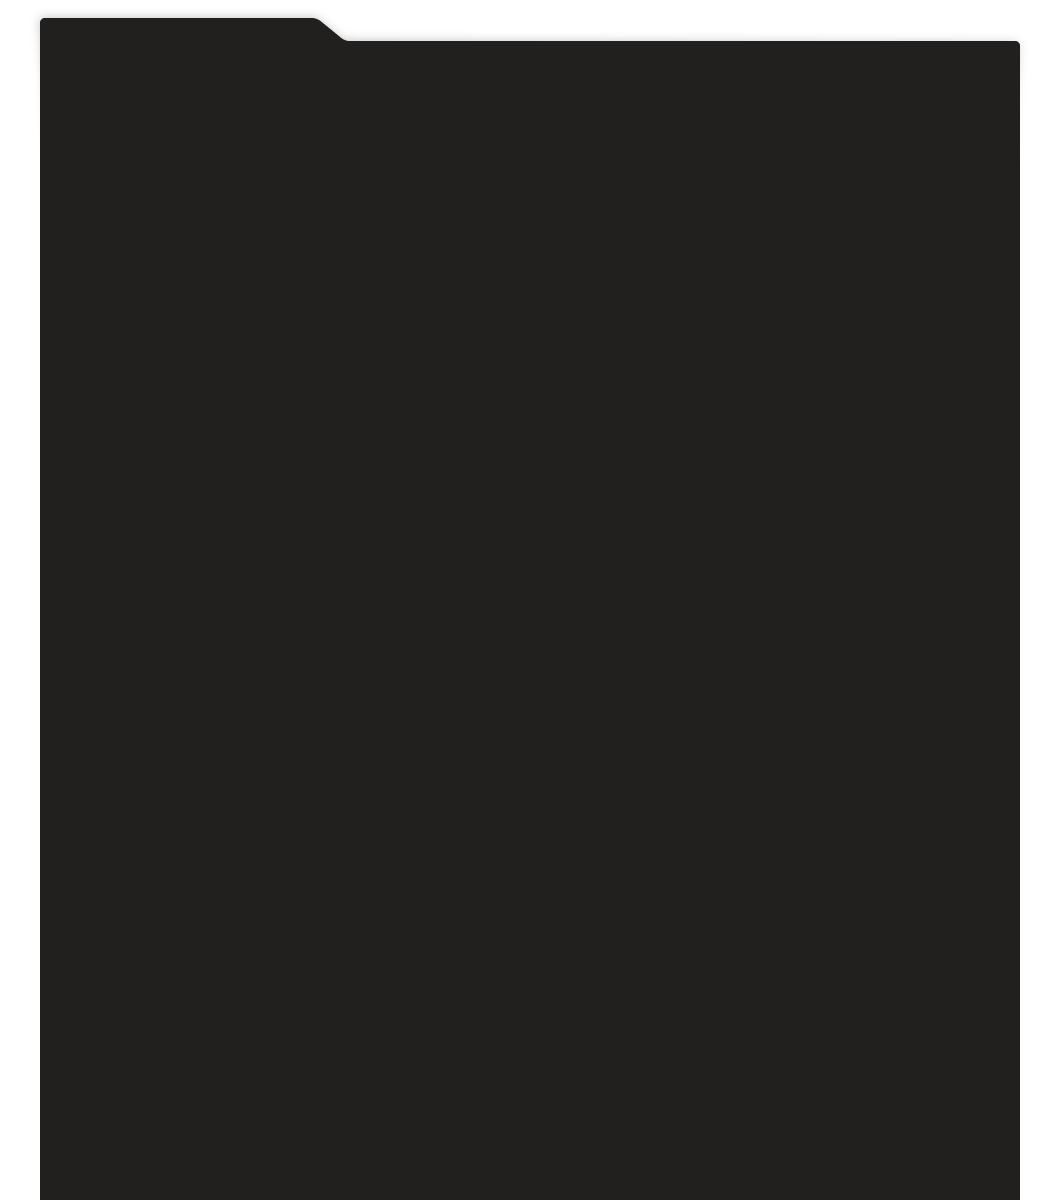
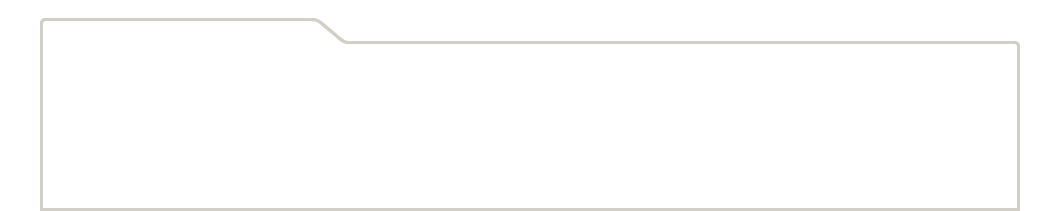
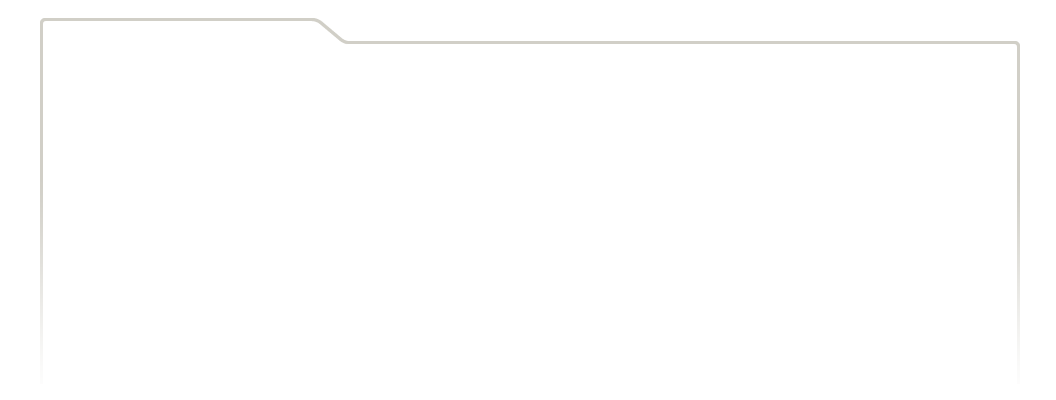
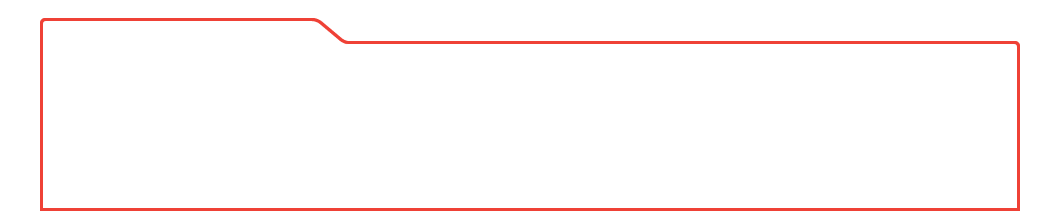
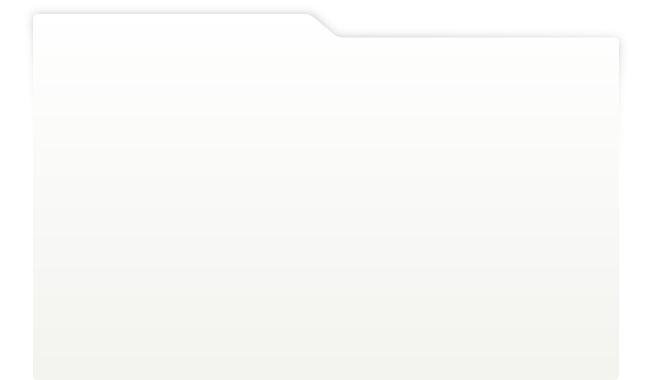
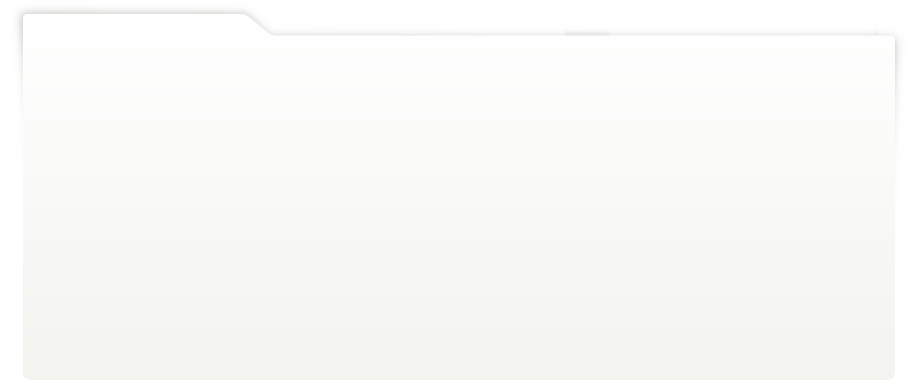
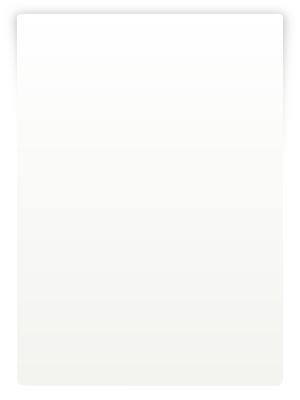
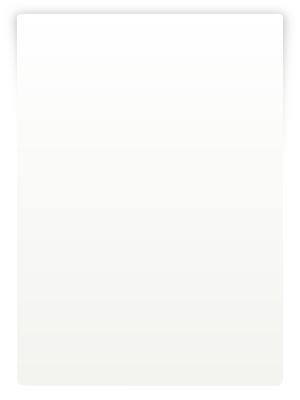
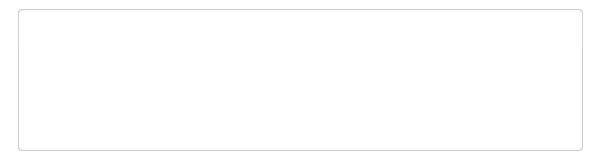
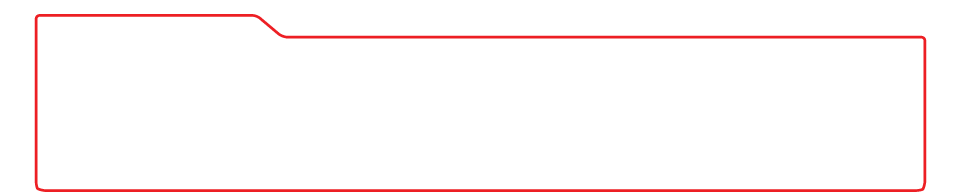
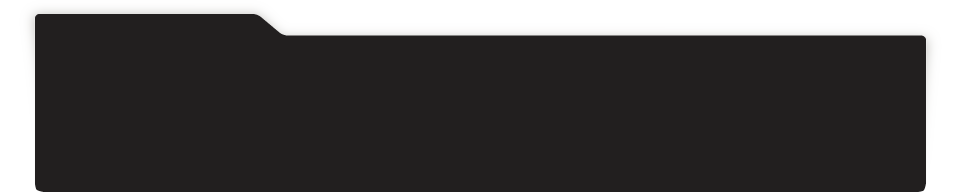
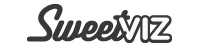
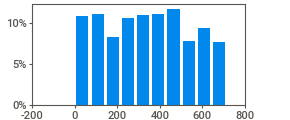
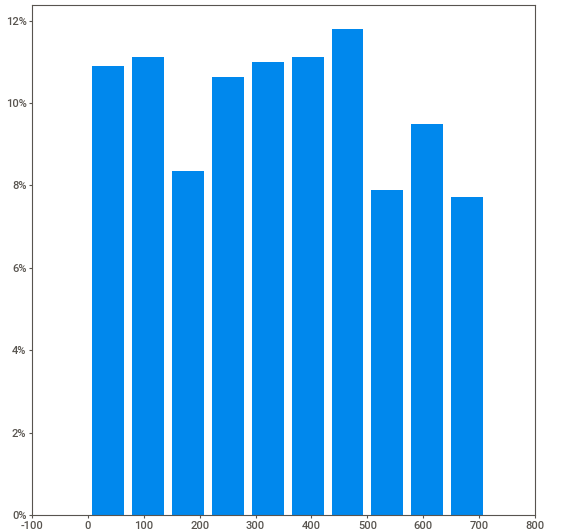
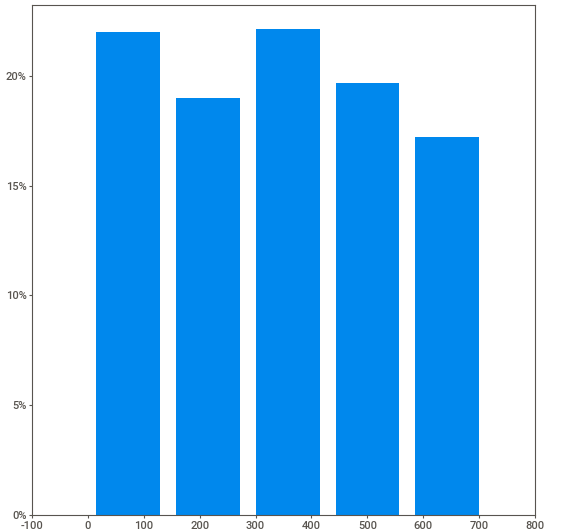
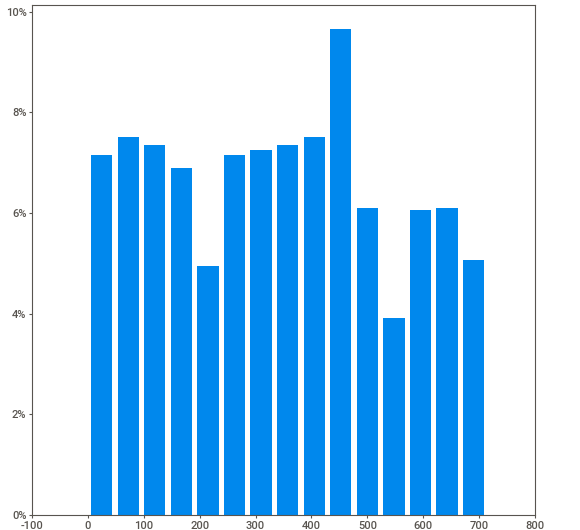
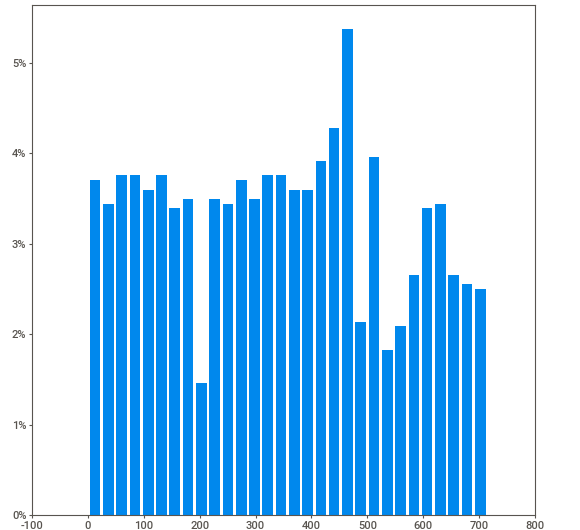
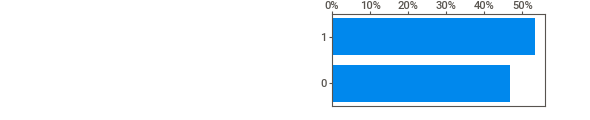
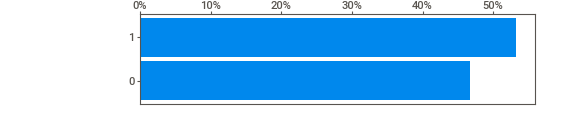
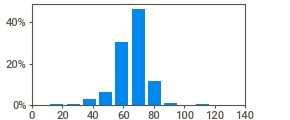
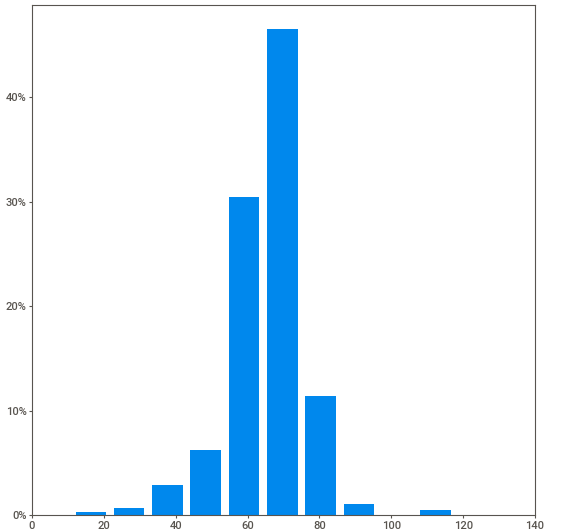
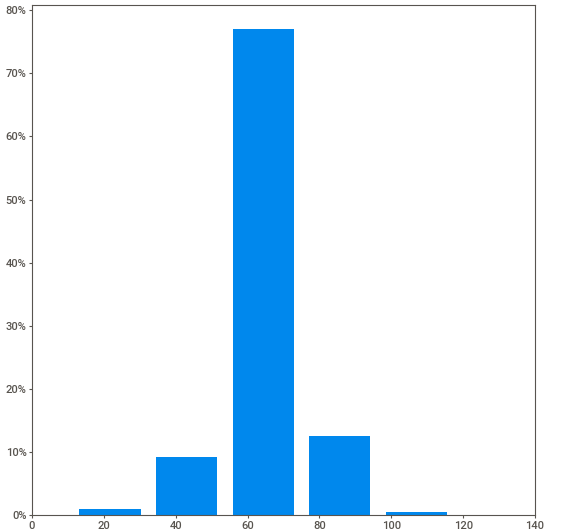
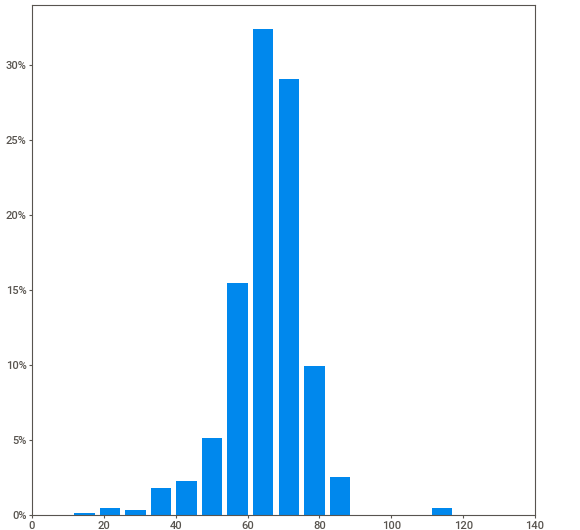
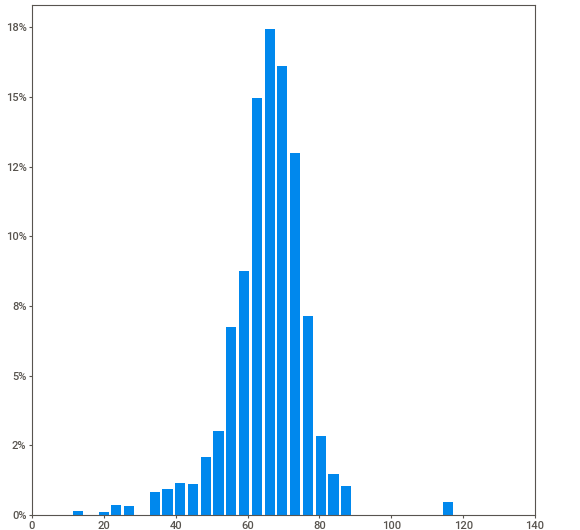
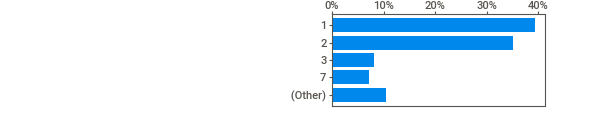
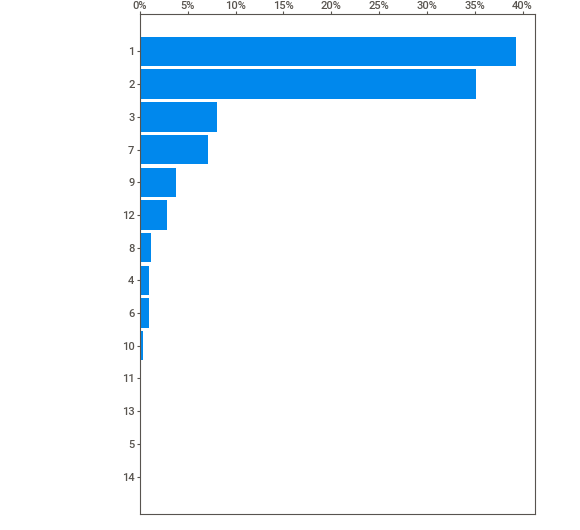
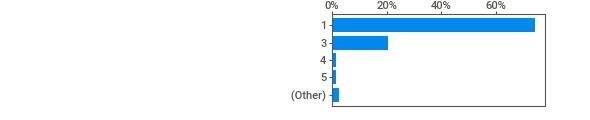
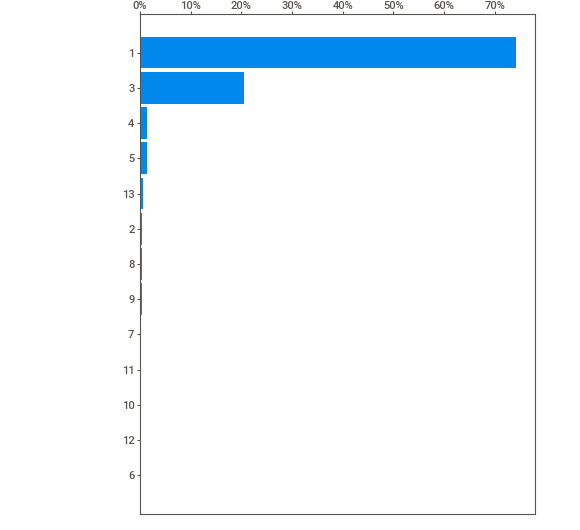
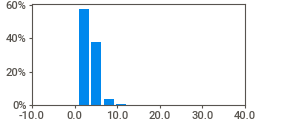
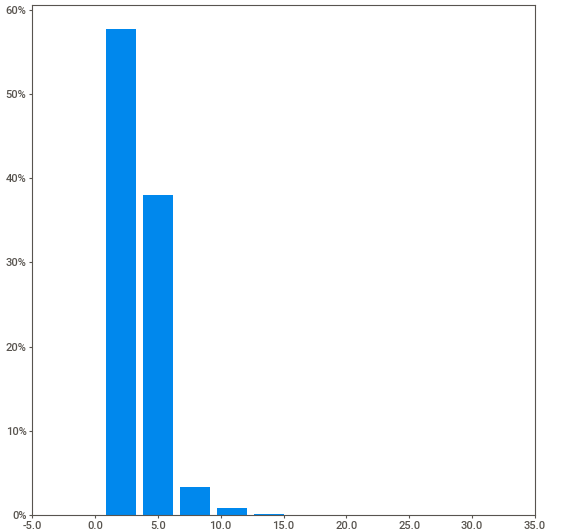
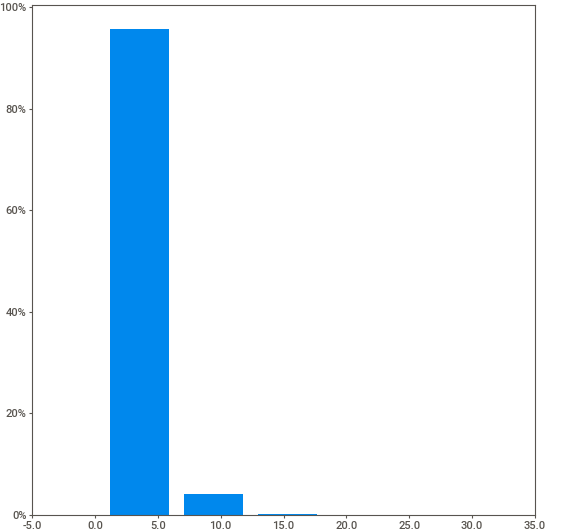
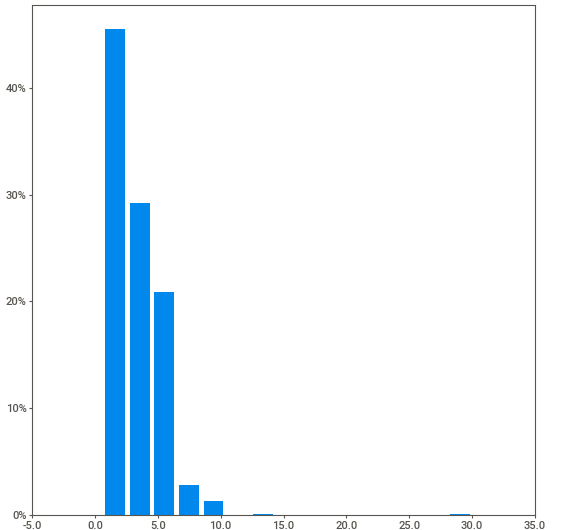
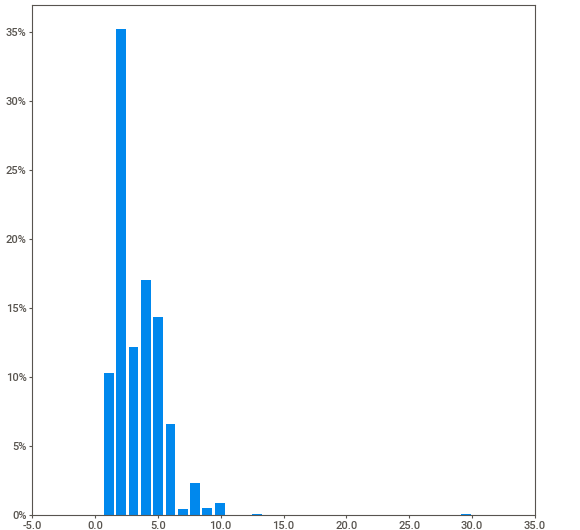
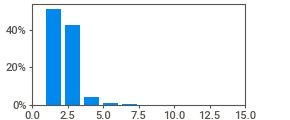
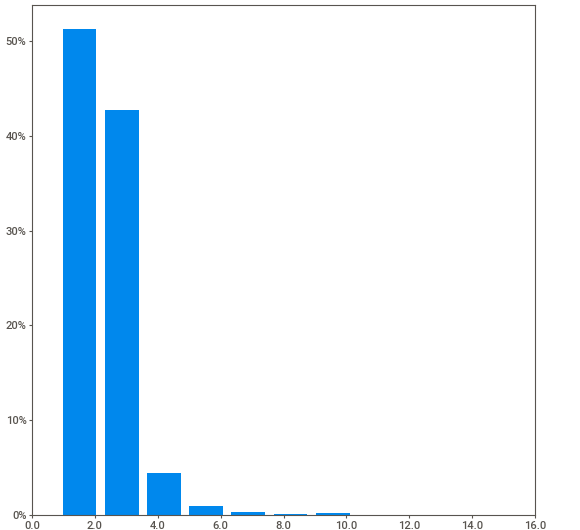
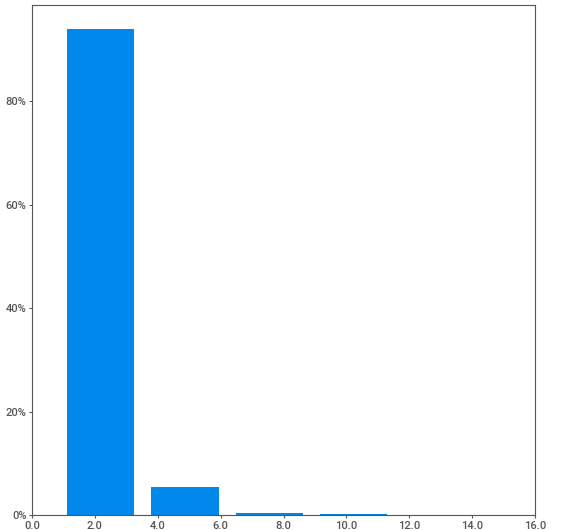
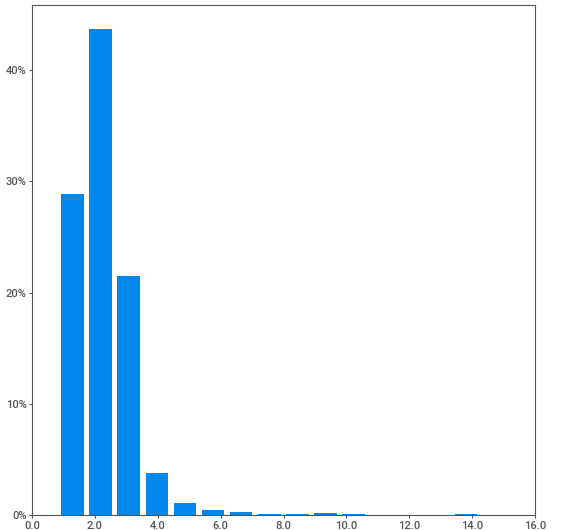
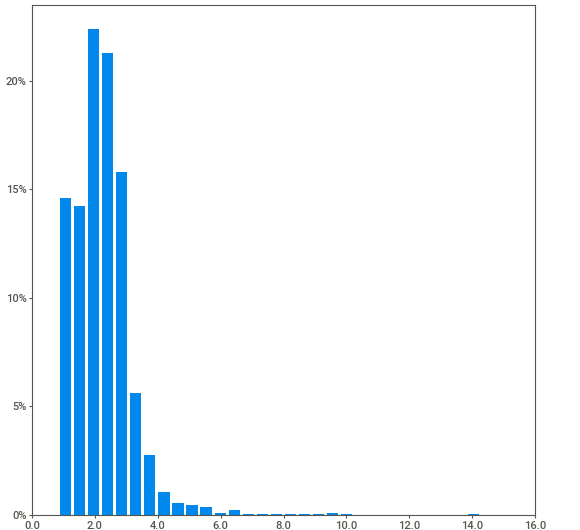
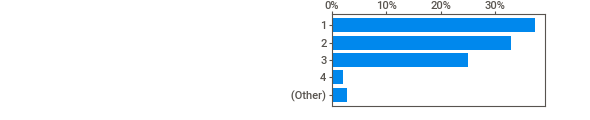
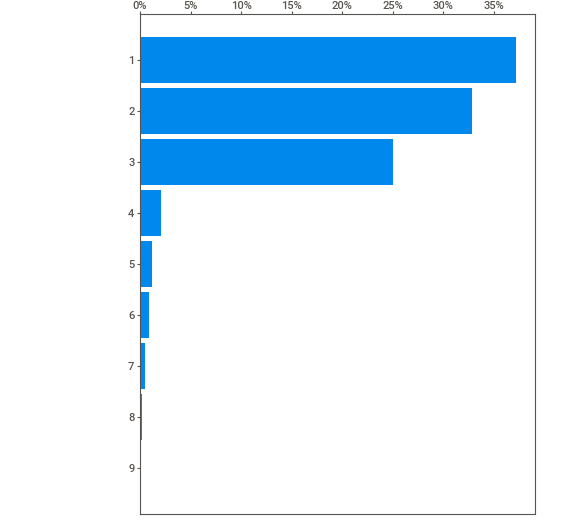
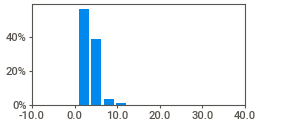
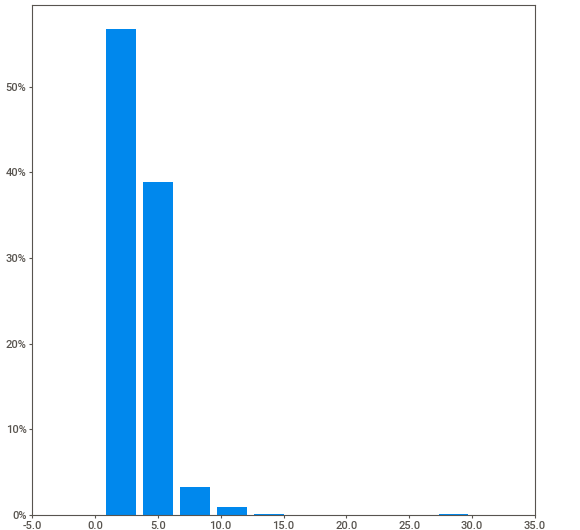
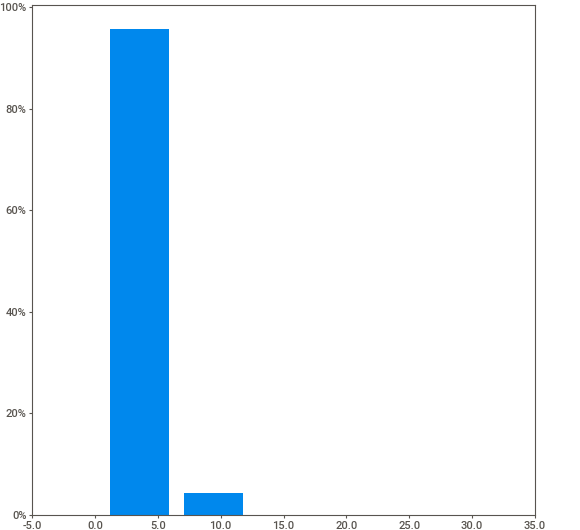
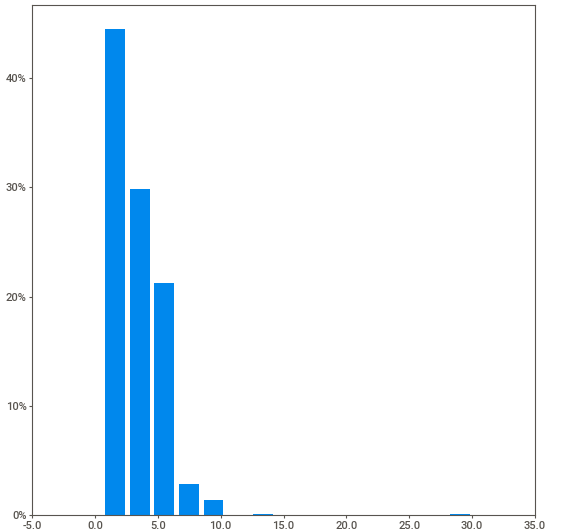
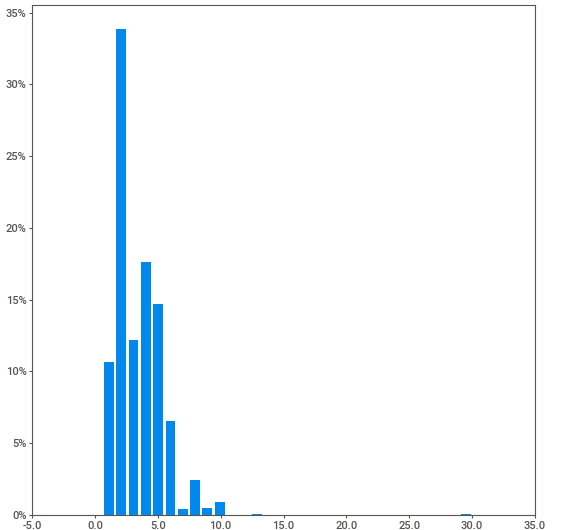
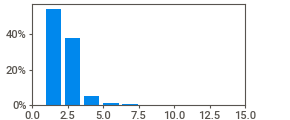
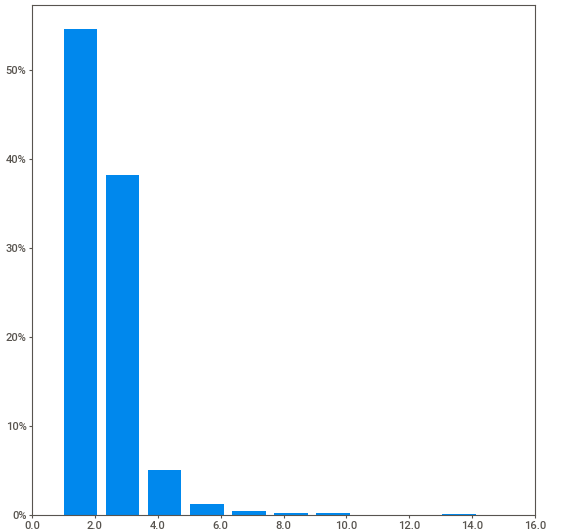
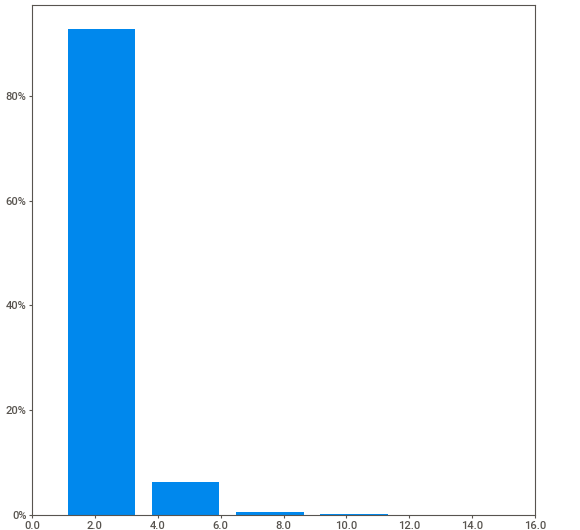
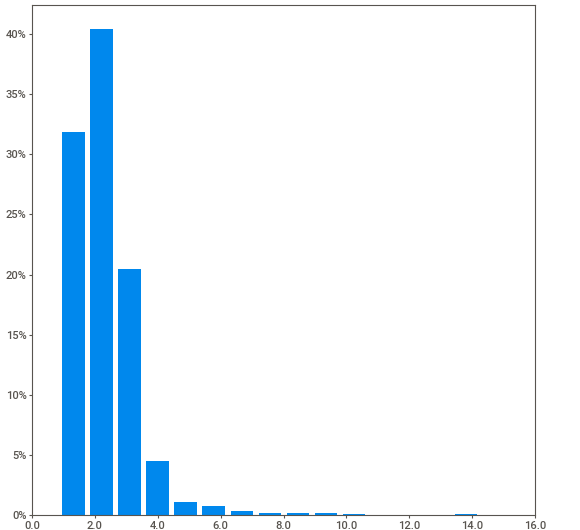
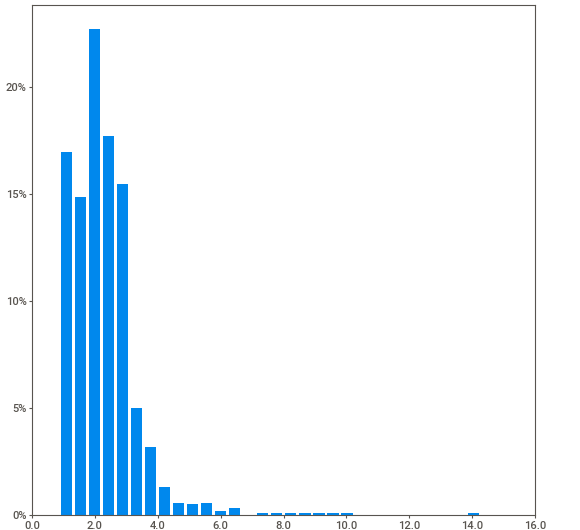
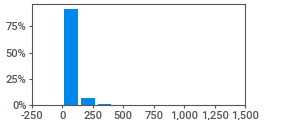
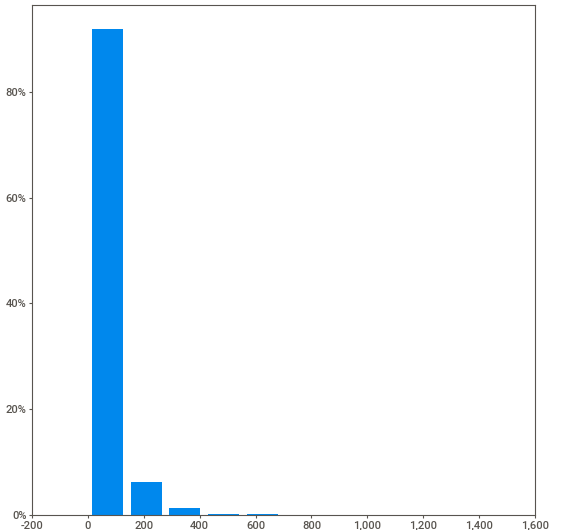
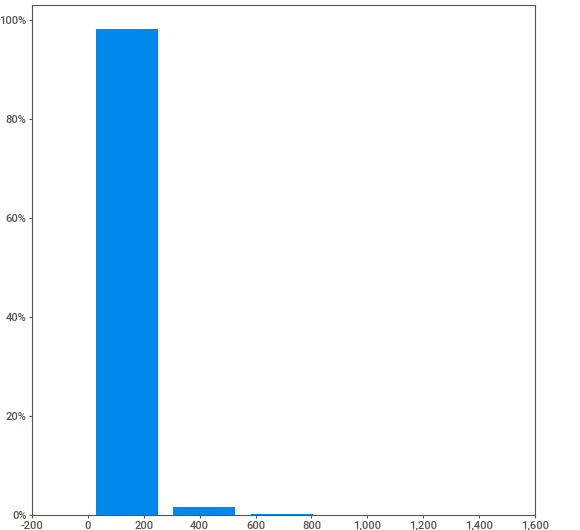
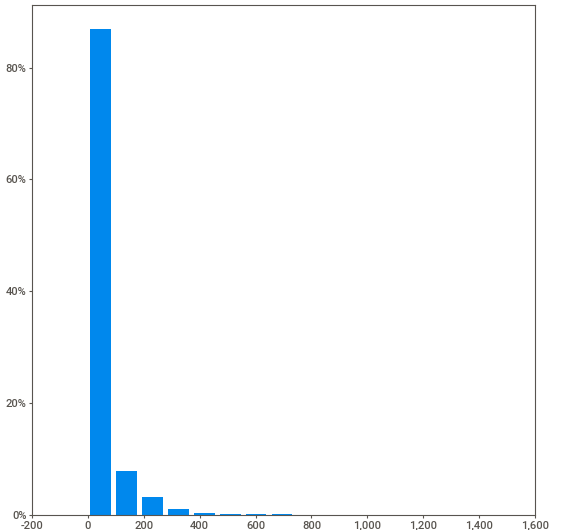
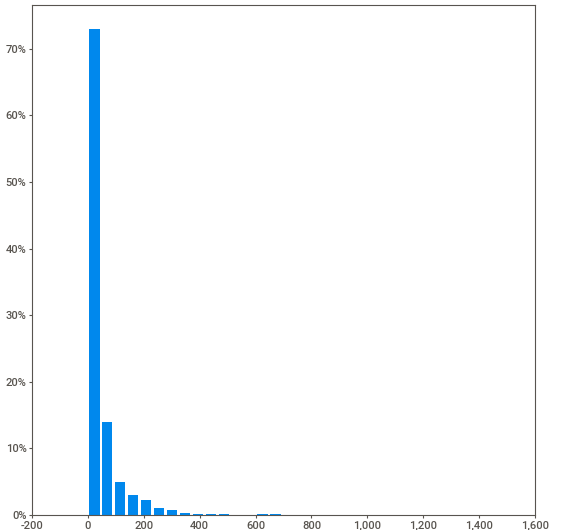
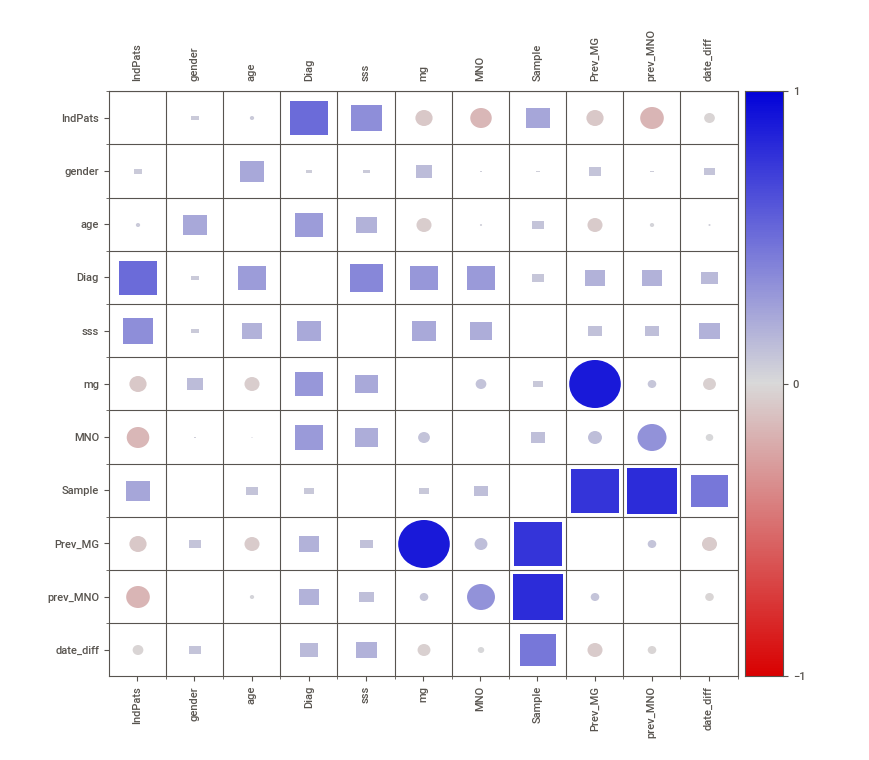
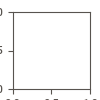

In [6]:
PATH = '/content/drive/MyDrive/Warfarin/'
fname = PATH+'dataForAll.xlsx'
df = pd.read_excel(fname)
df.Diag = df.Diag.astype('category')
df.sss = df.sss.astype('category')
df.sort_values(by=['IndPats', 'AnalisDate'], inplace=True)
#Конструируем дифференцаальные признаки
sample =1
df['Sample'] = 1
df['Prev_MG'] = np.nan
df['prev_MNO'] = np.nan
df['date_diff'] = 0
print(f'{fname}:{df.shape[0]} записей')
for i in range(1,df.shape[0]):
  if df.IndPats.iloc[i] == df.IndPats.iloc[i-1]:
    sample +=1
    df['Prev_MG'].iloc[i] = df.mg.iloc[i-1]
    df['prev_MNO'].iloc[i] = df.MNO.iloc[i-1]
    df['date_diff'].iloc[i] = (df.AnalisDate.iloc[i]-df.AnalisDate.iloc[i-1]).days
  else:
    sample = 1
  df['Sample'].iloc[i] = sample
df.reset_index()
with pd.ExcelWriter(fname[:-5]+'_dif.xlsx') as writer:
  df.to_excel(writer, sheet_name="Sheet1",index=False)
ar = sw.analyze(df)
ar.show_notebook()

['IndPats', 'gender', 'age', 'Diag', 'sss', 'mg', 'AnalisDate', 'MNO', 'Sample', 'Prev_MG', 'prev_MNO', 'date_diff']


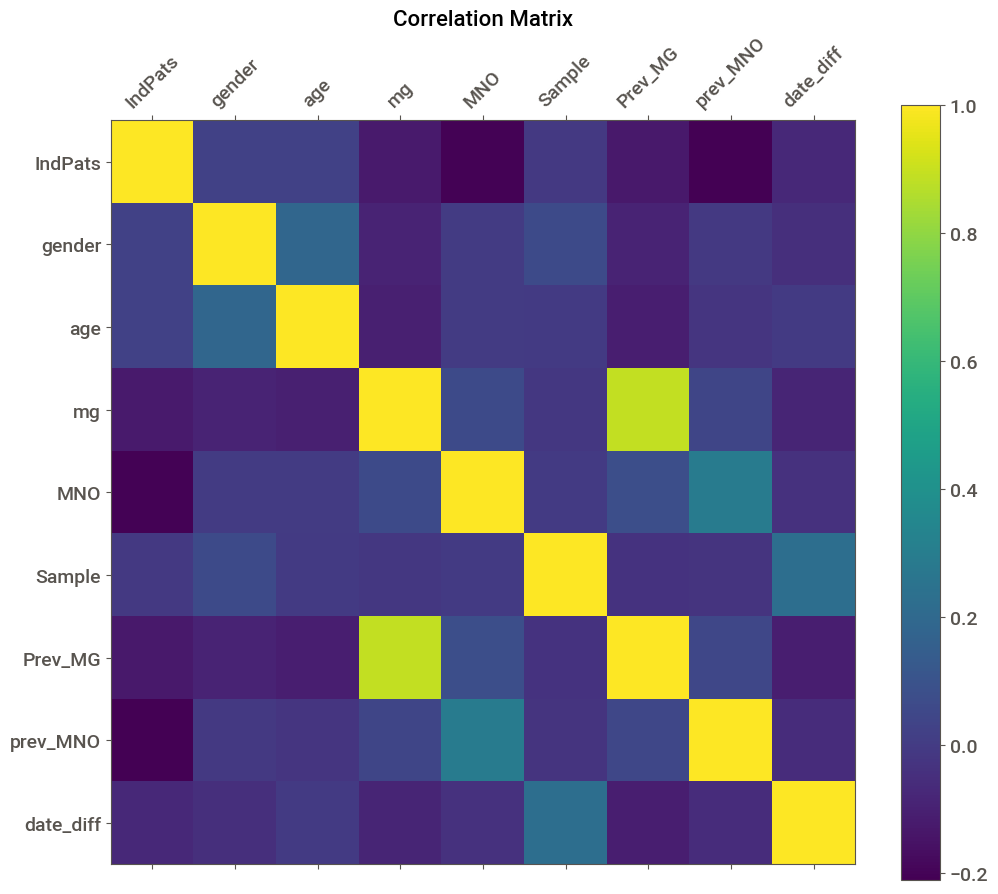

In [7]:
#print(df.mg.unique())
print(list(df))
df_corr = df.corr()
with pd.ExcelWriter(fname[:-5]+'_cor.xlsx') as writer:
  df_corr.to_excel(writer, sheet_name="Sheet1")
f = plt.figure(figsize=(12, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

[0.25 0.5  0.75]
[(0.25, 60.81587953), (0.5, 66.49144422), (0.75, 71.91512663)]
1859
Количество записей:1917, После фильтрации 689
   IndPats  gender        age     mg AnalisDate   MNO  Sample  Prev_MG  \
1        1       1  72.027379  3.125 2022-09-26  3.33       2    3.125   
2        1       1  72.027379  3.125 2023-01-24  3.95       3    3.125   
4        2       0  64.780287  3.750 2022-12-19  2.15       2    3.750   
5        2       0  64.780287  3.750 2023-01-11  2.45       3    3.750   
7        3       1  55.808350  6.250 2022-12-07  1.49       2    6.250   

   prev_MNO  date_diff  ...  sss_7  sss_8  sss_9  sss_10  sss_11  sss_12  \
1      3.07          7  ...      0      0      0       0       0       0   
2      3.33        120  ...      0      0      0       0       0       0   
4      2.49         31  ...      0      1      0       0       0       0   
5      2.15         23  ...      0      1      0       0       0       0   
7      1.51         23  ...      0      0   

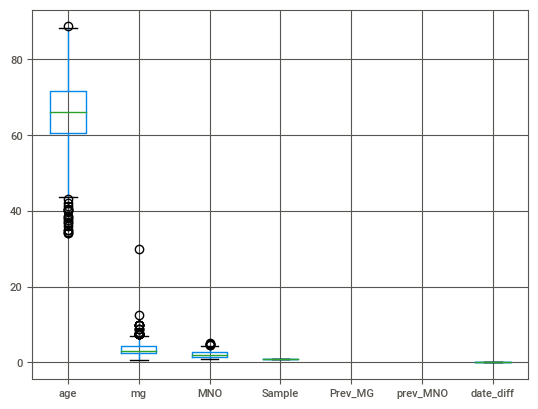

In [8]:
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split

import smogn
from scipy import stats

#df.dropna(inplace=True)
df = pd.read_excel(os.path.join(PATH,fname[:-5]+'_dif.xlsx'))

len = df.shape[0]
test_len = round(len * .2)
# Убираем выбросы
df.reset_index()
df = df[np.abs(df.age-df.age.mean()) <= (3*df.age.std())]
df = df[np.abs(df.MNO-df.MNO.mean()) <= (3*df.MNO.std())]
# Парсим категории
df.Diag = df.Diag.astype('category')
df.sss = df.sss.astype('category')

df = pd.get_dummies(df, prefix=['Diag','sss'])



#df = pd.concat([df,pd.get_dummies(df, columns=['sss'], prefix='sss')])

#превращаем возраст в AGE_RANGE равные возрастные группы
AGE_RANGE = 3
range_list = np.linspace(0, 1, AGE_RANGE+1, endpoint=0)
range_list = range_list[1:]
print (range_list)
age_q = df.age.quantile(range_list).to_numpy()
df['age'+f'{int(age_q[0])}'] = (df.age < age_q[0]).astype(int) # First Value
for i in range(1,AGE_RANGE-1):
  df['age'+f'{int(age_q[i])}'] = ((df.age >= age_q[i]) & (df.age <age_q[i+1])).astype(int)
df['age'+f'{int(age_q[AGE_RANGE-1])}'] = (df.age >= age_q[AGE_RANGE-1]).astype(int) # LAST Value
print(f'{[(range_list[i],age_q[i]) for i in range(AGE_RANGE)]}')

names = [
#        'IndPats',
        'gender',
        'age',
        'Diag',
        'sss',
        'mg',
#        'AnalisDate',
        'MNO',
        'Sample',
        'Prev_MG',
        'prev_MNO',
        'date_diff'
        ]
df1 = df[df['Sample'] == 1]
#df1 = df1.drop(columns=[ 'Prev_MG','prev_MNO','date_diff'])

df1.dropna()
#df1.Diag = df1.Diag.astype(int)
#df1.sss = df1.sss.astype(int)
print (df.shape[0])

print(f'Количество записей:{len}, После фильтрации {df1.shape[0]}')
names.remove('Diag')
names.remove('sss')

dboxplot = df1.boxplot(column=names[1:])
#X = df[names].to_numpy()
#Y = df[['dose']].to_numpy()
data = df[names]
df.dropna(inplace=True)
print(df.head())
train,test = train_test_split(df,test_size=0.2, random_state=33)
#print(train.shape,list(train))
#print(train.head())
#%pdb on

#train.drop(columns=['AnalisDate'],inplace=True)
#test.drop(columns=['AnalisDate'],inplace=True)

#train_smogn = smogn.smoter(data = train,y='MNO')
names = df.columns.tolist()
names.remove('age')
names.remove('AnalisDate')
names.remove('mg')
x_train = train[names].to_numpy()
y_train = train['mg'].to_numpy()
x_test = test[names].to_numpy()
y_test = test['mg'].to_numpy().astype('float')

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

#x_train = X_train
#y_train = Y_train

In [9]:
#@title Пробуем аугментацию


In [10]:
#@title Базовая модель
from IPython.display import HTML

# Display the plotly visualization in the notebook
#HTML(filename='catboost_info/learn.html')

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
cat = CatBoostRegressor()
cat.fit(x_train,y_train,verbose=False, plot=False)
from catboost import Pool, cv
params = {"iterations": 3000,
          "depth": 2,
          "loss_function": "MAPE",
          "boosting_type" : 'Ordered',
          "verbose": False}
cv_dataset = Pool(data=x_train,
                  label=y_train)
if False: '''
model = cv(cv_dataset,
            params,
            fold_count=5,
            plot="False",
            return_models = True)
'''



In [11]:
mape =[]
mae =[]
y_pred = cat.predict(x_test)
for i in range(y_test.shape[0]):
  mae1 = abs(y_test[i]-y_pred[i])
  m = mae1 /y_test[i]
  mape.append(m)
  mae.append(mae1)
mape = np.asarray(mape)
mae = np.asarray(mae)
print(f'Средний показатель МНО:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()}')

Средний показатель МНО:3.557418651214143, MAPE = 7.735921687989969 МАЕ = 0.19727170406804329


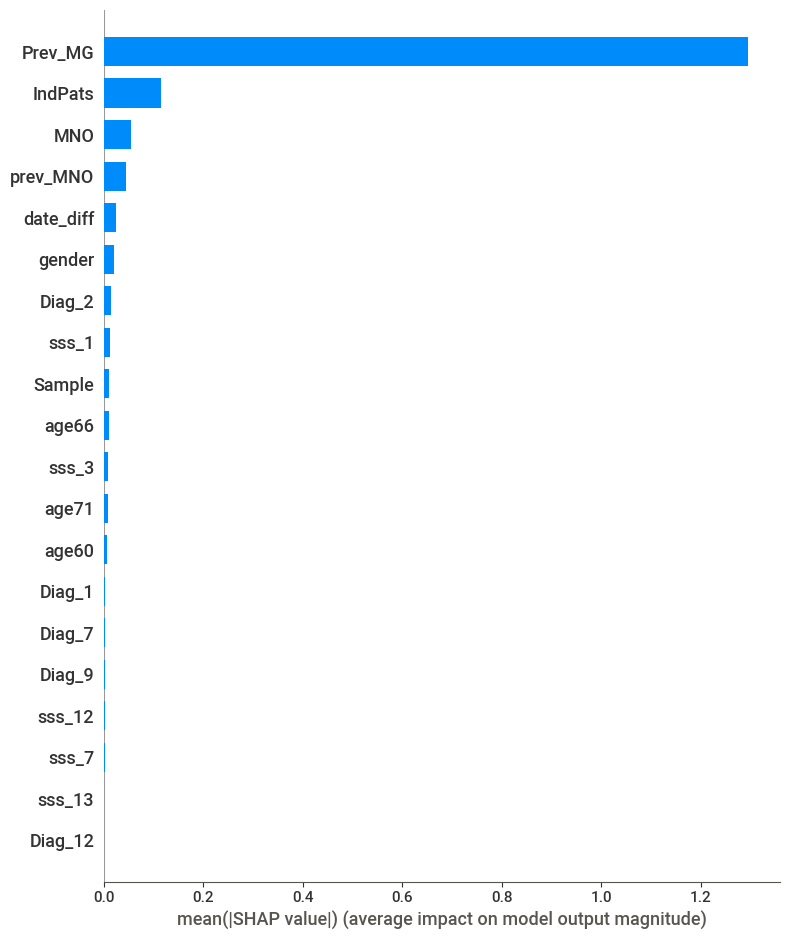

In [12]:
#@title Объяснялки
explainer = shap.Explainer(cat)
shap_values = explainer(x_test)
#shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = names)

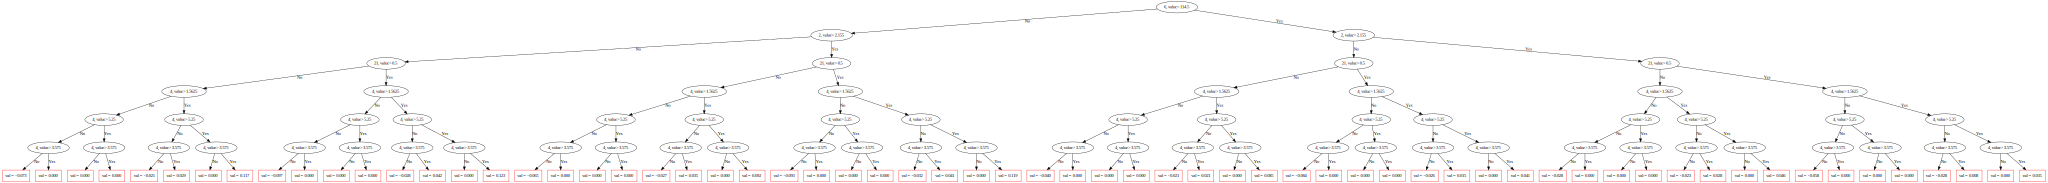

In [13]:
cat.plot_tree(tree_idx=0)

In [14]:
#@title TPOT (фреймворк AUTOML) у меня дает лучший результат
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
tpot.export('tpot_warfarin_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.1886107689462097

Generation 2 - Current best internal CV score: -0.18846426632763663

Generation 3 - Current best internal CV score: -0.1766456894999687

Generation 4 - Current best internal CV score: -0.1766456894999687

Generation 5 - Current best internal CV score: -0.1707900133083415

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=2, n_estimators=100)
-0.2192366169797603


In [23]:

from sklearn.ensemble import RandomForestRegressor

training_features, testing_features, training_target, testing_target = \
  x_train,x_test,y_train,y_test


# Average CV score on the training set was: -0.1886107689462097
exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=7, min_samples_split=7, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
y_pred = exported_pipeline.predict(testing_features)
mape =[]
mae =[]
#r2 = []
for i in range(y_test.shape[0]):
  mae1 = abs(y_test[i]-y_pred[i])
  m = mae1 /y_test[i]
  mape.append(m)
  mae.append(mae1)
  r2=r2_score(y_test,y_pred)
mape = np.asarray(mape)
mae = np.asarray(mae)
#r2 = np.asarray(r2)
print(f'Средний показатель МНО:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()} R2 = {r2}')


Средний показатель МНО:3.558398286492117, MAPE = 6.474477402675492 МАЕ = 0.18575491972711583 R2 = 0.9308563675867056


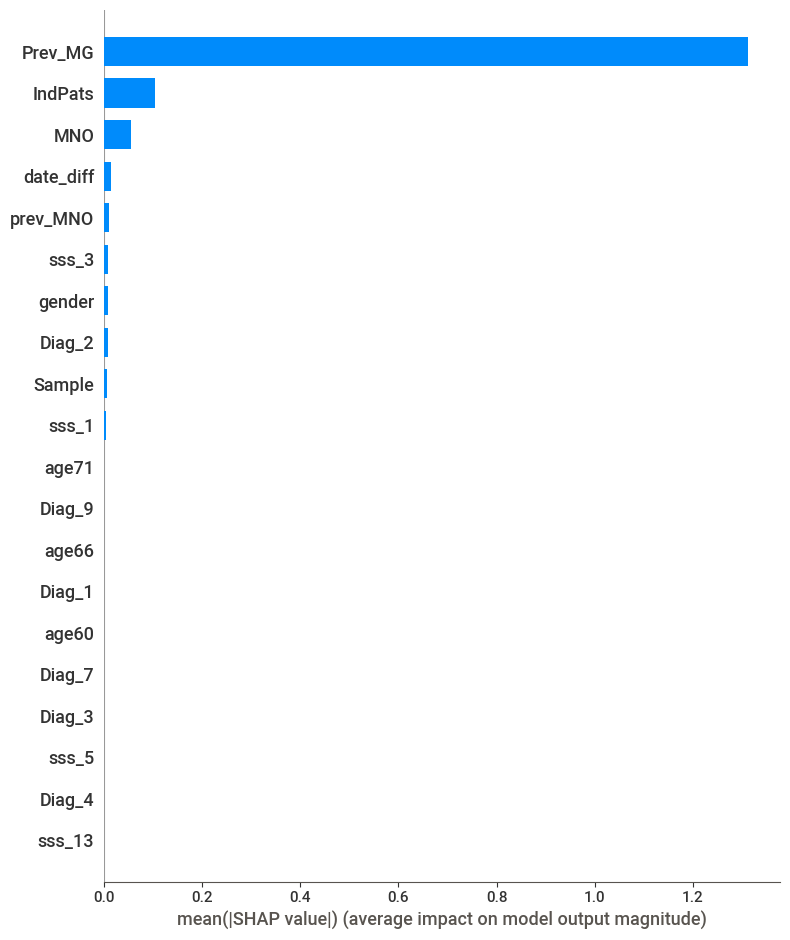

In [24]:
#@title Объяснялки
explainer = shap.Explainer(exported_pipeline)
shap_values = explainer(x_test)
#shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = names)

In [25]:
#@title AUTOML
from flaml import AutoML
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 1,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "warfarin.log",
}
# Train with labeled input data
automl.fit(X_train=x_train, y_train=y_train,
           **automl_settings)
# Print the best model
print(automl.model.estimator)

[flaml.automl.logger: 08-16 17:16:03] {1679} INFO - task = regression
[flaml.automl.logger: 08-16 17:16:03] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-16 17:16:03] {1788} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 08-16 17:16:03] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 08-16 17:16:03] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-16 17:16:03] {2344} INFO - Estimated sufficient time budget=544s. Estimated necessary time budget=5s.
[flaml.automl.logger: 08-16 17:16:03] {2391} INFO -  at 0.1s,	estimator lgbm's best error=0.5394,	best estimator lgbm's best error=0.5394
[flaml.automl.logger: 08-16 17:16:03] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-16 17:16:03] {2391} INFO -  at 0.1s,	estimator lgbm's best error=0.5394,	best estimator lgbm's best error=0.5394
[flaml.automl.logger: 08-16 17:16:03]

In [27]:
mape =[]
mae =[]
y_pred = automl.predict(x_test)
for i in range(y_test.shape[0]):
  mae1 = abs(y_test[i]-y_pred[i])
  m = mae1 /y_test[i]
  mape.append(m)
  mae.append(mae1)
mape = np.asarray(mape)
mae = np.asarray(mae)
r2=r2_score(y_test,y_pred)
print(f'Средний показатель МНО:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()} R2 = {r2}')


Средний показатель МНО:3.5694599557658213, MAPE = 9.249319501640393 МАЕ = 0.22939672534543248 R2 = 0.9462335125902899


In [ ]:
#@title нормализуем данные

if False:'''
scaler = MinMaxScaler()
scaler.fit(x_train)
scaler.transform(x_train)
scaler.transform(x_test)
'''


In [ ]:
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop, Nadam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,EarlyStopping

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [ ]:
# Обучение модели на простых данных
filepath = PATH+'/Bestmodel.h5'
cp = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
es = EarlyStopping(monitor="val_mape",patience=10,restore_best_weights=True, mode ='min')
model_simple = Sequential()
model_simple.add(Dense(512,
                       kernel_regularizer=regularizers.L2(0.1),
                       activation='relu',
                       input_dim=x_train.shape[1]))
#model_simple.add(Dense(256, activation='relu'))
#model_simple.add(Dropout(0.2))
model_simple.add(BatchNormalization())
#model_simple.add(Dense(1000, activation='tanh'))
#model_simple.add(Dropout(0.5))

model_simple.add(Dense(256,
#                       kernel_regularizer=regularizers.L2(0.1),
                       activation='relu'))
#model_simple.add(Dropout(0.5))
#model_simple.add(Dense(512,
#                       kernel_regularizer=regularizers.L2(0.1),
#                       activation='relu'))
model_simple.add(Dropout(0.5))
model_simple.add(Dense(15, activation='elu'))
model_simple.add(Dense(1, activation='linear'))

model_simple.compile(optimizer=Adam(learning_rate=1e-3),
#                     loss = [SparseCategoricalFocalLoss(gamma=2)],
                     loss=  'mse',
                     metrics=['mape'])

history = model_simple.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.2,
                    callbacks = [cp],
                    verbose=1)
plt.plot(history.history['mape'][5:],
            label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mape'][5:],
            label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.xlim([25, 100])
plt.legend()
plt.show()


In [ ]:
model_simple = load_model(filepath)
model_simple.compile(optimizer=Adam(learning_rate=1e-4),
#                     loss = [SparseCategoricalFocalLoss(gamma=2)],
                     loss=  'mse',
                     metrics=['mape'])
history = model_simple.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=256,
                    validation_split=0.2,
                    callbacks = [cp,es],
                    verbose=1)
plt.plot(history.history['mape'][5:],
            label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mape'][5:],
            label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.xlim([25, 100])
plt.legend()
plt.show()

In [ ]:
mape =[]
y_pred = model_simple.predict(x_test)
for i in range(y_test.shape[0]):
  m = abs(y_test[i]-y_pred[i])/y_test[i]
  mape.append(m)
mape = np.asarray(mape)
print(f'Средняя предсказанная доза:{y_pred.mean()}, MAPE = {mape.mean()*100}')

In [ ]:
# compute SHAP values
if False: '''
explainer = shap.DeepExplainer(model_simple, x_train)
shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = names)
'''